Verifying image: test_data\eac21001\eac21001.jpg
Verifying image: test_data\eac21025\eac21025.jpg
Verifying image: test_data\ester\ester.jpg
Verifying image: test_data\goodupita\goodupita.jpg
Verifying image: test_data\hellukundi\hellukundi.jpg
Verifying image: test_data\hemanth\hemanth.jpg
Verifying image: test_data\Hiranya\Hiranya.jpg
Verifying image: test_data\kausthub\kausthub.jpg
Verifying image: test_data\kolip\kolip.jpg
Verifying image: test_data\likhith\likhith.jpg
Verifying image: test_data\lohith@19\lohith@19.jpg
Verifying image: test_data\lohith@19\Screenshot 2024-11-02 122204.png
Verifying image: test_data\lucky234\lucky234.jpg
Verifying image: test_data\madhu\madhu.jpg
Verifying image: test_data\madhucharan123\madhucharan123.jpg
Verifying image: test_data\magic peach\magic peach.jpg
Verifying image: test_data\medusa\medusa.jpg
Verifying image: test_data\meghanab00478\meghanab00478.jpg
Verifying image: test_data\mohith\mohith.jpg
Verifying image: test_data\neehar\neehar.jpg

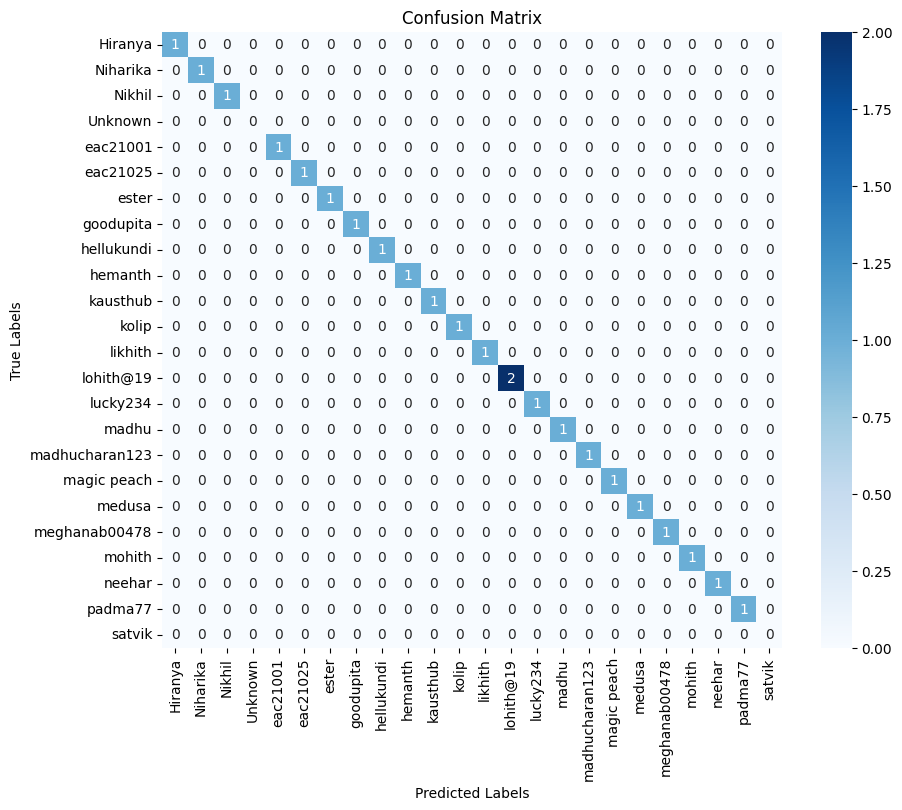

In [3]:
import os
import dlib
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Load the trained face recognition model
with open("model.pkl", "rb") as f:
    model_data = pickle.load(f)
    face_features_known_list = model_data["face_features"]
    face_name_known_list = model_data["face_names"]

# Load Dlib's models
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('dlib/shape_predictor_68_face_landmarks.dat')
face_reco_model = dlib.face_recognition_model_v1("dlib/dlib_face_recognition_resnet_model_v1.dat")


def return_euclidean_distance(feature_1, feature_2):
    """Calculate Euclidean distance between two 128D feature vectors."""
    feature_1 = np.array(feature_1)
    feature_2 = np.array(feature_2)
    return np.sqrt(np.sum(np.square(feature_1 - feature_2)))


def predict(image_path):
    """Predict the name of the person in the given image."""
    print(f"Verifying image: {image_path}")  # Print the image being processed
    img = cv2.imread(image_path)

    # Check if image is loaded correctly
    if img is None:
        print(f"Warning: Could not load image {image_path}. Skipping this file.")
        return "Unknown"

    faces = detector(img, 1)

    # Check if any face is detected
    if len(faces) == 0:
        return "Unknown"

    # Use the first face detected
    shape = predictor(img, faces[0])
    face_descriptor = face_reco_model.compute_face_descriptor(img, shape)

    # Compare the face descriptor to all known face descriptors
    distances = [return_euclidean_distance(face_descriptor, known_face) for known_face in face_features_known_list]
    min_distance_index = np.argmin(distances)

    # Define a threshold to determine if the face is recognized
    if distances[min_distance_index] < 0.4:
        return os.path.splitext(face_name_known_list[min_distance_index])[0]  # Remove file extension
    else:
        return "Unknown"


# Prepare true labels and predicted labels
true_labels = []
predicted_labels = []

# Directory containing test images for each person
test_data_path = "test_data"

# Iterate through each person's folder in the test dataset
for person_name in os.listdir(test_data_path):
    person_folder_path = os.path.join(test_data_path, person_name)

    # Skip if not a directory
    if not os.path.isdir(person_folder_path):
        continue

    # Use each image in the person's folder as a test case
    for image_name in os.listdir(person_folder_path):
        image_path = os.path.join(person_folder_path, image_name)

        # Predict the label of the current test image
        predicted_name = predict(image_path)
        true_labels.append(person_name)
        predicted_labels.append(predicted_name)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average="weighted", zero_division=1)
recall = recall_score(true_labels, predicted_labels, average="weighted", zero_division=1)
f1 = f1_score(true_labels, predicted_labels, average="weighted", zero_division=1)

# Print evaluation results
print("Model Evaluation Metrics:")
print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=sorted(set(true_labels + ["Unknown"])))
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=sorted(set(true_labels + ["Unknown"])),
            yticklabels=sorted(set(true_labels + ["Unknown"])))
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
